<div style="font-family: Times">
<span style="font-size: 22px">
Demonstration of frequency detuning prediction for the FRIB RFQ and the implementation of MPC.
</span>
</div>

In [1]:
import tensorflow as tf
import numpy as np
import time
from scipy.optimize import minimize
from copy import deepcopy
import matplotlib.pyplot as plt
import joblib
from LSTM_Koopman_Model import *


<div style="font-family: Times">
<span style="font-size: 20px">
The LSTM-based Koopman network model is loaded. 


The model consists of a LSTM network, a dense network and a Koopman network.
</span>
</div>

In [2]:
# load the trained model
model = tf.keras.models.load_model('model.h5',custom_objects={'encoder': encoder, 'Koopman': Koopman, 'decoder': decoder})

# load the scalers to scale the data
sc_x = joblib.load('sc_x.pkl')
sc_d = joblib.load('sc_d.pkl')
sc_i = joblib.load('sc_i.pkl')


In [12]:
# load test data used in the paper
test_data = np.load('Test_samples.npz')
delay_array = test_data['delay_array']
instant_array = test_data['instant_array']
frq_array = test_data['frq_array']
true_array = test_data['true_array']

<div style="font-family: Times">
<span style="font-size: 20px">
Evaluate the model with test samples and compare the predictions with the measured frequency detuning.
</span>
</div>

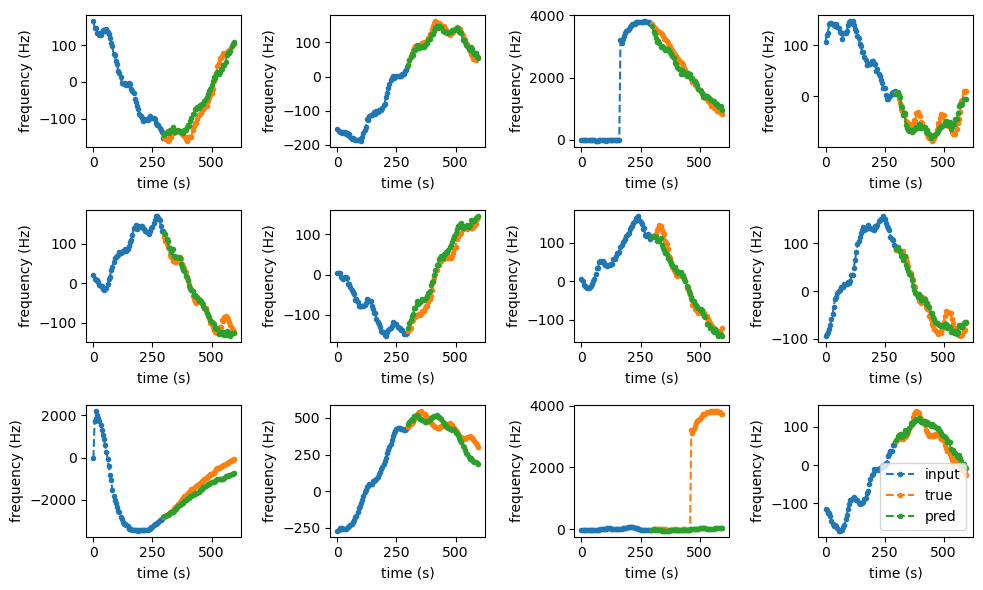

In [13]:
# evaluate the model
# delay_array:    historical time-delayed variables, such as water teperature, water pressure and the control actions of two valves.
# instant_array:  historical non-delayer variables, including foward power, reflected power and electric field.
# frq_array:      historical measured frequency detuning. 

pred_array = model.predict([delay_array, instant_array, frq_array])

# plot the results

pred_array = sc_x.inverse_transform(pred_array)
real_array = sc_x.inverse_transform(true_array)
real_prev = sc_x.inverse_transform(frq_array)
plt.figure(figsize=(10, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.plot(range(0,300,5), real_prev[i,:], '--.', label='input' )
    plt.plot(range(300,600,5), real_array[i,:], '--.', label='true' )
    plt.plot(range(300,600,5), pred_array[i,:], '--.', label='pred')
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
plt.legend()
plt.tight_layout()

<div style="font-family: Times">
<span style="font-size: 20px">
Implementation of MPC based on Particl Swarm Optimization (PSO).
</span>
</div>

In [5]:
sample_index = 12 # Frequency detuning occurs here 

# objective and f calculate MSE of the predicted frequency detuning corresponding to a specific setting of the control actions u1 and u2 within 300-600s
# u1:       control actions of CV2 
# u2:       control actions of CV3
def f(u1, u2):
    sample_delay = delay_array[sample_index, :, :]
    real_f = sc_x.inverse_transform(true_array[sample_index,:].reshape((60,1)))
    sample_instant = instant_array[sample_index, :].reshape((1,3))
    sample_frq = frq_array[sample_index,:].reshape((1,60))
    sample_delay = sc_d.inverse_transform(sample_delay)
    new_sample_delay = deepcopy(sample_delay)
    new_sample_delay[60:,6] = u1
    new_sample_delay[60:,7] = u2
    new_sample_delay = sc_d.transform(new_sample_delay).reshape((1,120,8))

    optimized_f = model.predict([new_sample_delay, sample_instant, sample_frq])
    optimized_f_real = sc_x.inverse_transform(optimized_f.reshape(60,1))
    optimized_f_real_sq = optimized_f_real**2
    weights = np.geomspace(1, 100, 60)
    weights = weights / np.sum(weights)
    weighted_sum = np.sum(optimized_f_real_sq.flatten() * weights)
    
    return weighted_sum

def objective(u):
    u1 = u[:int(len(u)/2)]
    u2 = u[int(len(u)/2):]
    return f(u1, u2)


# constraints of the optimization
# particles:        particles of the PSO
# u1_range:         lower and upper bound of CV2
# u2_range:         lower and upper bound of CV3
# max_change:       allowed maximum change in the control actions between two adjacent time steps.

def apply_constraints(particles, u1_range, u2_range, max_change = 1):
    n_steps = particles.shape[1] // 2
    
    particles[:, :n_steps] = np.clip(particles[:, :n_steps], u1_range[0], u1_range[1])
    particles[:, n_steps:] = np.clip(particles[:, n_steps:], u2_range[0], u2_range[1])

    for i in range(particles.shape[0]):  
        u1 = particles[i, :n_steps]
        u2 = particles[i, n_steps:]

        # Clip the change in u1 and u2 to not exceed max_change
        u1_diff = np.diff(u1)
        u1_diff = np.clip(u1_diff, -max_change, max_change)
        particles[i, 1:n_steps] = u1[0] + np.cumsum(u1_diff)

        u2_diff = np.diff(u2)
        u2_diff = np.clip(u2_diff, -max_change, max_change)
        particles[i, n_steps+1:] = u2[0] + np.cumsum(u2_diff)

    return particles

# Particle Swarm Optimization
# the intiial population is generated based on the control actions of CV2 and CV3 at 300s

sample_delay = delay_array[sample_index, :, :]
sample_delay = sc_d.inverse_transform(sample_delay)
u_init = np.zeros(120)
u_init[:60] = sample_delay[60,6] # CV2 at 300s
u_init[60:] = sample_delay[60,7] # CV3 at 300s

def particle_swarm_optimization(f, n_particles, n_iterations, dim, u1_range, u2_range):
    start_time = time.time()
    w = 0.5
    c1 = 0.5
    c2 = 0.9

    best_u1_history = []
    best_u2_history = []


    sigma = 1  # Standard deviation for Gaussian noise
    # generate initial population
    particles = u_init + sigma * np.random.randn(n_particles, dim)
    velocities = np.random.uniform(-1, 1, (n_particles, dim))
    particles = apply_constraints(particles, u1_range, u2_range)

    pbest_positions = np.copy(particles)
    pbest_scores = np.apply_along_axis(lambda x: f(x[:dim//2], x[dim//2:]), 1, particles)

    gbest_score = np.min(pbest_scores)
    gbest_position = np.copy(pbest_positions[np.argmin(pbest_scores)])

    for i in range(n_iterations):
        if time.time() - start_time >= 3000:  # Stop after time is up
            break

        velocities = w * velocities + c1 * np.random.random((n_particles, dim)) * (pbest_positions - particles) \
                    + c2 * np.random.random((n_particles, dim)) * (gbest_position - particles)

        particles += velocities
        particles = apply_constraints(particles, u1_range, u2_range)

        scores = np.apply_along_axis(lambda x: f(x[:dim//2], x[dim//2:]), 1, particles)

        better_pbest = np.less(scores, pbest_scores)
        pbest_positions[better_pbest] = particles[better_pbest]
        pbest_scores[better_pbest] = scores[better_pbest]

        current_gbest_score = np.min(pbest_scores)
        if current_gbest_score < gbest_score:
            gbest_score = current_gbest_score
            gbest_position = np.copy(pbest_positions[np.argmin(pbest_scores)])

        best_u1_history.append(gbest_position[:dim//2])
        best_u2_history.append(gbest_position[dim//2:])

        print(f"Iteration {i+1}: Best score = {gbest_score}")

    return gbest_position, gbest_score, best_u1_history, best_u2_history

# Parameters
u1_range = (0, 80)      # range for CV2
u2_range = (0, 80)      # range for CV3
n_particles = 20        # population size
n_iterations = 20       # maximum number of iterations
T = 300                 # predicted time horizon
dt = 5                  # time interval
n_steps = int(T / dt)   # number of time steps
dim = 2 * n_steps       # number of all control actions for u1 and u2 

# Run PSO
best_position, best_score, best_u1_history, best_u2_history = particle_swarm_optimization(f, n_particles, n_iterations, dim, u1_range, u2_range)


# Extract best u1 and u2
best_u1 = best_position[:n_steps]
best_u2 = best_position[n_steps:]

print("Best score:", best_score)
print("Best u1:", best_u1)
print("Best u2:", best_u2)

Iteration 1: Best score = 2399540.8351736106
Iteration 2: Best score = 2191686.1655562473
Iteration 3: Best score = 928269.6590856179
Iteration 4: Best score = 775636.0109342899
Iteration 5: Best score = 710980.3278752873
Iteration 6: Best score = 710980.3278752873
Iteration 7: Best score = 710980.3278752873
Iteration 8: Best score = 710980.3278752873
Iteration 9: Best score = 682219.9231589179
Iteration 10: Best score = 682219.9231589179
Iteration 11: Best score = 653460.1038075144
Iteration 12: Best score = 638131.1575447732
Iteration 13: Best score = 620248.5150845549
Iteration 14: Best score = 620248.5150845549
Iteration 15: Best score = 620248.5150845549
Iteration 16: Best score = 620248.5150845549
Iteration 17: Best score = 620248.5150845549
Iteration 18: Best score = 620248.5150845549
Iteration 19: Best score = 620248.5150845549
Iteration 20: Best score = 611582.5224676363
Best score: 611582.5224676363
Best u1: [34.95132192 35.55897814 34.90675171 34.50797024 35.22851562 34.2285

(array([26., 28., 30., 32., 34., 36., 38., 40., 42., 44.]),
 [Text(0, 26.0, '26'),
  Text(0, 28.0, '28'),
  Text(0, 30.0, '30'),
  Text(0, 32.0, '32'),
  Text(0, 34.0, '34'),
  Text(0, 36.0, '36'),
  Text(0, 38.0, '38'),
  Text(0, 40.0, '40'),
  Text(0, 42.0, '42'),
  Text(0, 44.0, '44')])

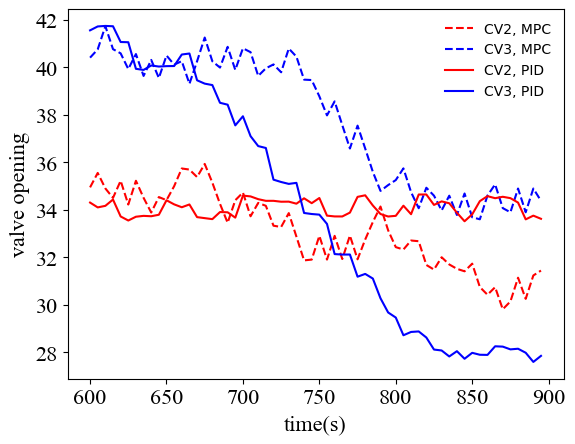

In [6]:
# plot the optimized control actions
# plot the comparison with the PID control

plt.plot(range(600,900,5),best_u1,'r--',label='CV2, MPC')
plt.plot(range(600,900,5),best_u2,'b--',label='CV3, MPC')
plt.plot(range(600,900,5),sample_delay[60:,6:8][:,0],'r',label='CV2, PID')
plt.plot(range(600,900,5),sample_delay[60:,6:8][:,1],'b',label='CV3, PID')

plt.legend(frameon=False)
plt.xlabel('time(s)',fontname='times new roman',fontsize=16)
plt.ylabel('valve opening',fontname='times new roman',fontsize=16)
plt.xticks(fontname='times new roman',fontsize=16)
plt.yticks(fontname='times new roman',fontsize=16)

C:\Users\WAN\AppData\Local\Temp\ipykernel_6428\254887999.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet', steps)
C:\Users\WAN\AppData\Local\Temp\ipykernel_6428\254887999.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, steps, 6), boundaries=np.arange(1, steps+1, 1))


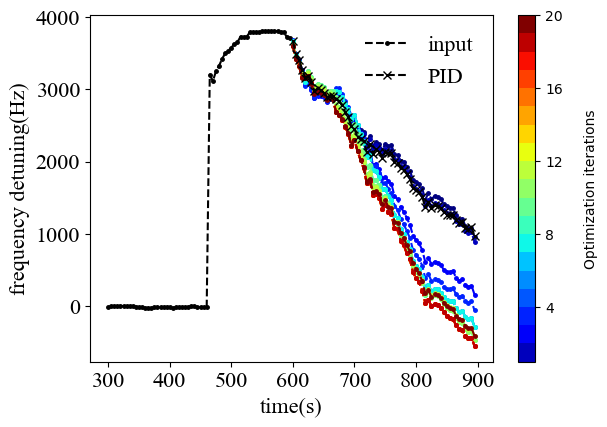

In [7]:
# plot the evolution of frquency detuning with the PSO
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager

def f_real(u1, u2):
    sample_delay = delay_array[sample_index, :, :]
    real_f = sc_x.inverse_transform(true_array[sample_index].reshape((60,1)))
    sample_instant = instant_array[sample_index, :].reshape((1,3))
    sample_frq = frq_array[sample_index,:].reshape((1,60))
    sample_delay = sc_d.inverse_transform(sample_delay)
    new_sample_delay = deepcopy(sample_delay)
    new_sample_delay[60:,6] = u1
    new_sample_delay[60:,7] = u2
    new_sample_delay = sc_d.transform(new_sample_delay).reshape((1,120,8))

    optimized_f = model.predict([new_sample_delay, sample_instant, sample_frq])
    optimized_f_real = sc_x.inverse_transform(optimized_f.reshape(60,1))
    non_op_f = model.predict([sc_d.transform(sample_delay).reshape((1,120,8)), sample_instant, sample_frq])
    non_op_f_real = sc_x.inverse_transform(non_op_f.reshape(60,1))
    prev_real = sc_x.inverse_transform(sample_frq.reshape(60,1))
    non_op_u1 = sample_delay[60:,6]
    non_op_u2 = sample_delay[60:,7]
    # print(np.mean(optimized_f_real**2))
    return optimized_f_real, prev_real, non_op_f_real, non_op_u1, non_op_u2
# Initialize color map
steps = 20
colormap = cm.get_cmap('jet', steps)  

plt.figure(figsize=(6.5, 4.5))
u1 = best_u1_history[0]
u2 = best_u2_history[0]
op, previous, non_op, non_op_u1, non_op_u2 = f_real(u1,u2)
    
plt.plot(range(300, 600, 5), previous, 'k--.', label='input',markersize=5)
for i in range(steps):  
    u1 = best_u1_history[i]
    u2 = best_u2_history[i]
    op, _, _,_,_ = f_real(u1, u2)
    norm_i = i / steps  # normalize i
    plt.plot(range(60*5+300, 300+120*5, 5), op, '--.', color=colormap(norm_i),markersize=5)
# Create colorbar
norm = plt.Normalize(0, steps) 
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, steps, 6), boundaries=np.arange(1, steps+1, 1))

cbar.set_label('Optimization iterations', rotation=90, labelpad=15)
plt.plot(range(300+60*5, 300+120*5, 5), non_op, 'k--x', label='PID')

font = font_manager.FontProperties(family='Times New Roman',size=16,
                            style='normal')
plt.legend(prop=font,frameon=False)
plt.xlabel('time(s)', fontsize=16, fontname="Times New Roman")
plt.ylabel('frequency detuning(Hz)', fontsize=16, fontname="Times New Roman")
plt.xticks(fontsize=16, fontname="Times New Roman")
plt.yticks(fontsize=16, fontname="Times New Roman")
    
plt.show()

